In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from scipy.stats import gamma
import scipy.integrate
import pandas
from hmf import MassFunction     # The main hmf class
# TO DO: Update to most recent Planck results
from astropy.cosmology import Planck18_arXiv_v2 as cosmo
import hmf
from hmf import functional
import winsound

In [2]:
# Path to tables of cosmic variance values
path = "../../CV_Vals/"
file='hmf'
save=1
# Get young, blue galaxy spectrum
data = np.loadtxt("../erb2010_continuum.dat")
x = data[:,0]
y = data[:,1] * x**2 / 3.e18 # Convert to correct flux values

# Constants
tot_sky = 41253. # Total degrees on the sky
masses = np.array([7.0, 7.5, 8.0, 8.5, 9.0, 9.5, 10.0, 10.5, 11.0]) # Mass bins in log(M/Msun)

# TO DO: Modify cosmic variance values from the tables such that masses <= 8 use the same cosmic variance values as 8.5
# Currently the CV values are incorrectly extrapolated to lower masses from a mass of 8.5
# The code used to calculated the CV values is called "getcv" and is included with the CV value files
#Done

trials = 10000 # Number of trials for calculating median from gamma function
mmin = 9 # Minimum halo mass for HMF
mmax = 13.5 # Maximum halo mass for HMF

In [3]:
# Function to find closest wavelength in measured galaxy spectrum compared to given value
def nearest_wavelength(x, val):
    i = (np.abs(x - val)).argmin()
    return x[i]

In [4]:
# Define a class for different survey designs
class survey:
    def __init__(self, ABmax, area, cv_file, wavelength = 0, num_pointings = 1):
        self.ABmax = ABmax # Limiting AB magnitude of the survey
        self.area = area # Survey area
        self.file = cv_file # Name of cosmic variance table file
        self.point = num_pointings # Number of independent pointings
        self.wavelength = wavelength # Center wavelength for the chosen filter

In [5]:
# Method to take one trial of a gamma distribution with a given variance and mean
def trial(sig_v, mean, trials=10000):
    var = sig_v**2*mean**2
    k = mean**2/var
    t = var/mean
    rand = np.rint(np.random.gamma(k, scale=t, size=trials))
    return rand

In [6]:
dfz = pandas.read_csv(path+"cv_mashian.csv")
z_vals=dfz["z"]
z_vals = z_vals[::-1]

In [7]:
val=[-0.04418885, -0.95909967]
def lin(x,a=val[0],b=val[1]):
    return a*x+b

In [8]:
# Find mean, median number of galaxies found for a given survey design
def mean_median(survey, correction = True, random=True):
    # Get survey information
    point = survey.point
    survey_area = survey.area * point
    ABmax = survey.ABmax 
    
    # Absolute magnitude range over which to integrate
    # Range is larger than necessary to include all galaxies
    
    # Redshift values from CV calculations 
    df = pandas.read_csv(path+survey.file)
    if random:
        z_vals = df["z"].values*np.random.uniform(0.975,1.02,size=1)
    else:
        z_vals = df["z"].values
    df.drop(columns=["z"])
    df["z"]=z_vals
    z_vals = z_vals[::-1]

    all_mean = []
    all_sig_v = []
    
    # Loop over z values
    for z in z_vals:
        # Get observed wavelength for a rest frame of 1600 Angstroms
        # Find closest wavelength to this value in the observed galaxy spectrum
        if correction:
            wl_obs = nearest_wavelength(x, 1600 * (1 + z))
            # Account for difference in observed magnitude due to difference in wavelength 
            # of the survey and the wavelength of the 
            shift=2.5 * np.log10(y[x==survey.wavelength]/y[x==wl_obs])
            ABmax_new = ABmax + shift
        else:
            ABmax_new=ABmax
        masses = np.array([7.0, 7.5, 8.0, 8.5, 9.0, 9.5, 10.0, 10.5, 11.0])    
        mf = MassFunction(cosmo_model=cosmo,z=z,Mmin=mmin,Mmax=mmax, hmf_model="SMT")
        # Find volume of space within redshift bin
        dz = df.loc[df['z'] == z][["dz"]].values[0][0]
        vol = cosmo.comoving_volume(z + dz/2).value - cosmo.comoving_volume(z - dz/2).value
        little_h=mf.cosmo_model.h
        mass=mf.m*little_h
        dndm=mf.dndm/little_h**3 #check when to multiply
        sbf=0.018
        stellar_mass=mass*sbf
        # Extrapolation of M*-MUV relation from Song 2016 to z = z
        if z<8:
            norm=lin(z)
        if z>8:
            norm=-1.313
        M_vals=2.*(norm - np.log10(stellar_mass))
        if correction:
            m = np.array(M_vals + cosmo.distmod(z).value)+shift
        else:
            m = np.array(M_vals + cosmo.distmod(z).value)
        u_lim = max(m)
        l_lim = min(m)
        u_lim = min(u_lim, ABmax_new) # Compare dimmest object to telescope limit

        index= m<=u_lim
        stellar_mass=stellar_mass[index]
        cum_n=hmf.integrate_hmf.hmf_integral_gtm(stellar_mass, dndm[index])
        means=[]
        sigs=[]
        for i in range(len(masses)):
            index=np.abs(stellar_mass - 10**masses[i]).argmin()
            integral=cum_n[index]
            means.append(integral * vol * survey_area / tot_sky)
            
            # Get cosmic variance value for this z value and mass bin
            # CV values calculated as in Moster et al. 2010
            sig_v = float(df.loc[df['z'] == z][[str(masses[i])]].values[0][0]) / np.sqrt(int(point))
            sigs.append(sig_v)

        # Append mean and variance values of all masses for this redshift 
        all_mean.append(means)
        all_sig_v.append(sigs)
        
    all_tot_mean = []
    all_med = []
    
    # Loop over all z values (high to low)
    for i in range(len(z_vals)):
        tot_mean = 0
        tot_trials = np.zeros(trials)
        # Find cumulative mean and median number of observed galaxies up to z
        for j in range(i+1):
            means = all_mean[j]
            sigs = all_sig_v[j]
            # Run trials of gamma distribution to find median
            for k in range(len(masses)):
                if means[k] != 0:
                    one_trial = trial(sigs[k], means[k])
                    tot_trials = tot_trials + one_trial
                    tot_mean += means[k]
        all_tot_mean.append(tot_mean)
        med = np.median(tot_trials)
        all_med.append(med)
    return np.array(all_tot_mean), np.array(all_med), z_vals

# Plots

100%|███████████████████████████████████████████████████████████████████████████████| 50/50 [1:39:29<00:00, 119.38s/it]


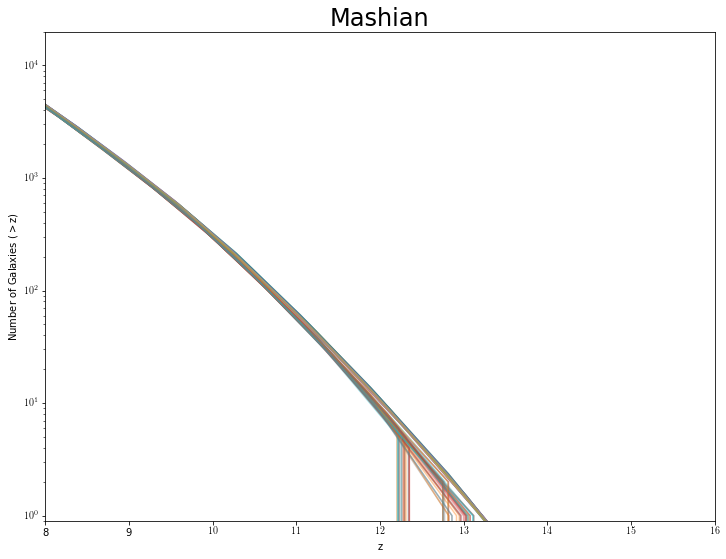

In [9]:
from tqdm import tqdm
N=50
fig, ax = plt.subplots(figsize=(12,9))
summed=np.zeros(len(z_vals))
summean=np.zeros(len(z_vals))
for _ in tqdm(range(N)):   
    # Survey design matching the idealized survey from Mashian et al. 2015
    mashian = survey(31.5, 200./3600, "cv_mashian.csv", nearest_wavelength(x,14873.4))
    mean_mashian, med_mashian, z_vals_mashian = mean_median(mashian, correction=False)
    summed+=med_mashian
    summean+=mean_mashian
    plt.rcParams.update({'font.size': 20})
    plt.rc('font', family='serif')
    plt.rc('text', usetex=True)

    ax.plot(z_vals_mashian, mean_mashian, alpha=0.4, label = "Mean")
    ax.plot(z_vals_mashian, med_mashian, alpha=0.4,label = "Median")

    ax.set(xlabel="z", ylabel="Number of Galaxies"r" ($>$z)", yscale="log", ylim=(0.9,2e4), xlim=(8,16), title='Mashian')
    if save==1:
        plt.savefig("figs/"+file+"/mashian.pdf")
winsound.Beep(400,300)

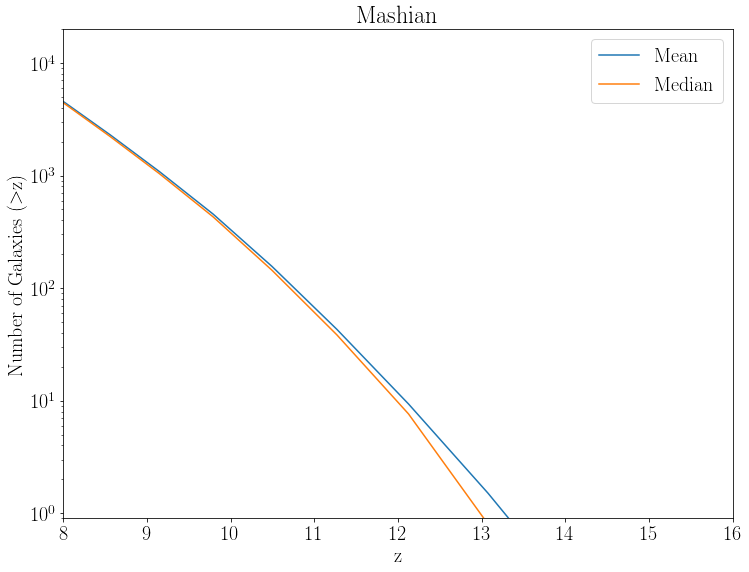

In [10]:
fig, ax =plt.subplots(figsize=(12,9))
plt.rcParams.update({'font.size': 20})
plt.rc('font', family='serif')
plt.rc('text', usetex=True)

ax.plot(z_vals, summean/N,label = "Mean")
ax.plot(z_vals, summed/N,label = "Median")
ax.legend()
ax.set(xlabel="z", ylabel="Number of Galaxies"r" ($>$z)", yscale="log", ylim=(0.9,2e4), xlim=(8,16), title='Mashian')
if save==1:
    plt.savefig("figs/"+file+"/mashian.pdf")

In [11]:
from scipy.interpolate import interp1d
fmed = interp1d(z_vals, summed/N, 'cubic')
fmean = interp1d(z_vals, summean/N, "cubic")
def find_min(f):
    x=8
    while f(x)>1:
        x+=0.001
    print(f(x))
    return x

z_med, z_mean = find_min(fmed), find_min(fmean)
z_med, z_vals[73-max(np.argwhere(np.isnan(np.log(summed)+np.inf)).flatten())], z_mean

0.9979665247966246
0.9993090432017453


C:\Users\chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log
  if sys.path[0] == '':
C:\Users\chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in add
  if sys.path[0] == '':


(12.990999999997234, 13.0755, 13.28599999999707)

100%|███████████████████████████████████████████████████████████████████████████████| 50/50 [1:38:52<00:00, 118.64s/it]


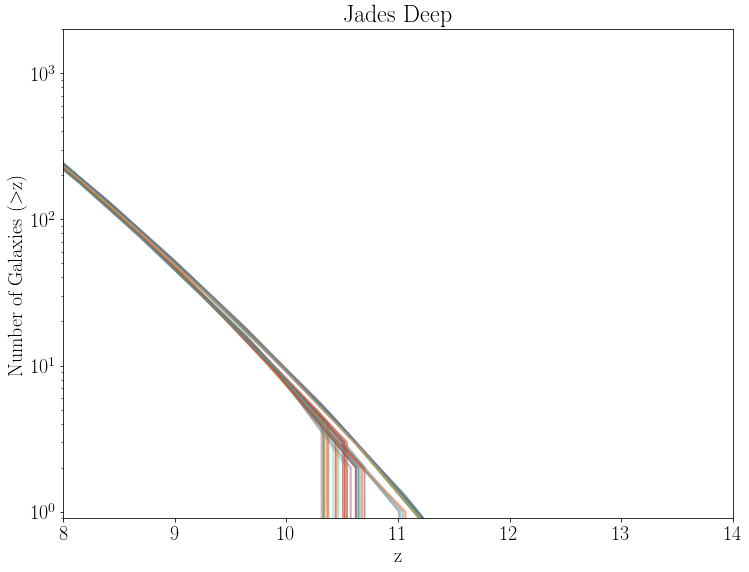

In [12]:
fig, ax = plt.subplots(figsize=(12,9))
meds, means = [],[]
summed=np.zeros(len(z_vals))
summean=np.zeros(len(z_vals))
for _ in tqdm(range(N)):   
    # Survey design matching the JADES Deep survey from Williams et al. 2018 (pg. 36)
    deep = survey(30.7, 46./3600, "cv_jades_deep.csv", nearest_wavelength(x,14873.4))
    mean_deep, med_deep, z_vals_deep = mean_median(deep)
    summed+=med_deep
    summean+=mean_deep
    meds.append(med_deep)
    means.append(mean_deep)
    ax.plot(z_vals_deep, mean_deep, alpha=0.4, label = "Mean")
    ax.plot(z_vals_deep, med_deep, alpha=0.4,label = "Median")

    ax.set(xlabel="z", ylabel="Number of Galaxies"r" ($>$z)", yscale="log", ylim=(0.9,2e3), xlim=(8,14), title='Jades Deep')
winsound.Beep(400,300)

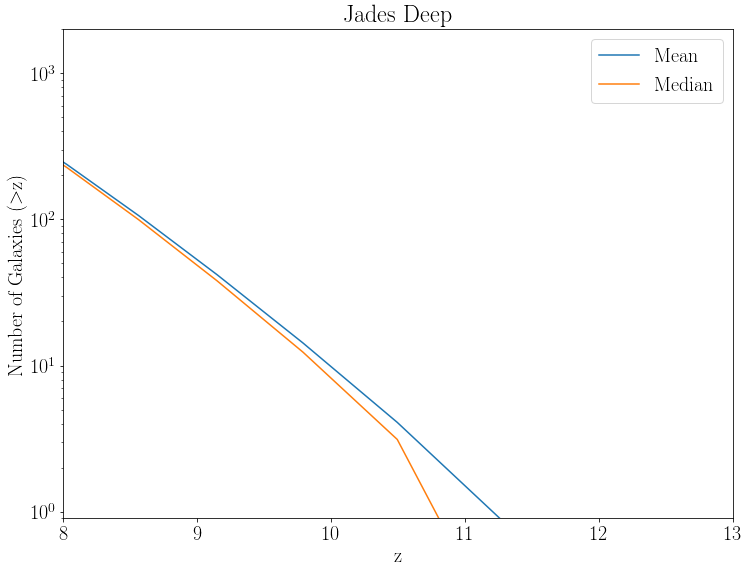

In [13]:
fig, ax =plt.subplots(figsize=(12,9))

ax.plot(z_vals, summean/N,label = "Mean")
ax.plot(z_vals, summed/N,label = "Median")
ax.legend()
ax.set(xlabel="z", ylabel="Number of Galaxies"r" ($>$z)", yscale="log", ylim=(0.9,2e3), xlim=(8,13), title='Jades Deep')
if save==1:
    plt.savefig("figs/"+file+"/jadesdeep.pdf")

In [14]:
fmed = interp1d(z_vals, summed/N, 'cubic')
fmean = interp1d(z_vals, summean/N, "cubic")
z_med, z_mean = find_min(fmed), find_min(fmean)
z_med, z_vals[73-max(np.argwhere(np.isnan(np.log(summed)+np.inf)).flatten())], z_mean

0.9967641475502981
0.9987324035996681


C:\Users\chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
C:\Users\chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in add
  after removing the cwd from sys.path.


(10.911999999998386, 11.2695, 11.21099999999822)

100%|███████████████████████████████████████████████████████████████████████████████| 50/50 [1:39:33<00:00, 119.47s/it]


0.9966953175429575
0.9993494014359061


C:\Users\chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in log
C:\Users\chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in add


(11.612999999997998, 11.2695, 11.872999999997853)

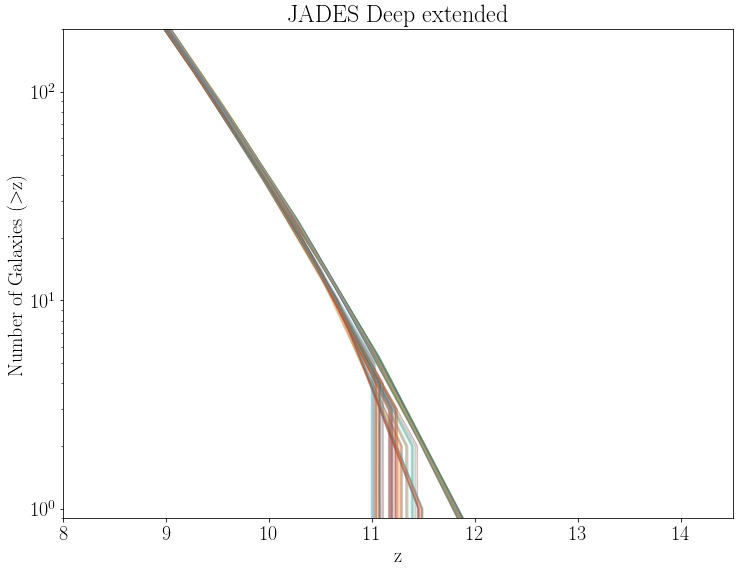

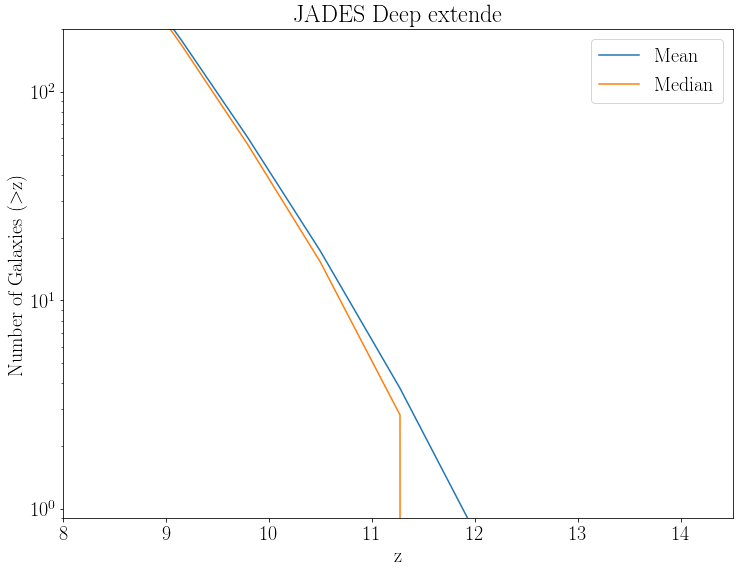

In [15]:
from scipy.interpolate import interp1d
from tqdm import tqdm
N=50
def find_min(f):
    x=8
    while f(x)>1:
        x+=0.001
    print(f(x))
    return x
fig, ax = plt.subplots(figsize=(12,9))
meds, means = [],[]
summed=np.zeros(len(z_vals))
summean=np.zeros(len(z_vals))
for _ in tqdm(range(N)):   
    # Survey design matching the JADES Deep survey from Williams et al. 2018 (pg. 36)
    deep = survey(30.7, 190./3600, "cv_jades_deep_extend.csv", nearest_wavelength(x,14873.4))
    mean_deep, med_deep, z_vals_deep = mean_median(deep)
    summed+=med_deep
    summean+=mean_deep
    meds.append(med_deep)
    means.append(mean_deep)
    ax.plot(z_vals_deep, mean_deep, alpha=0.4, label = "Mean")
    ax.plot(z_vals_deep, med_deep, alpha=0.4,label = "Median")

    ax.set(xlabel="z", ylabel="Number of Galaxies"r" ($>$z)", yscale="log", ylim=(0.9,2e2), xlim=(8,14.5), title='JADES Deep extended')
winsound.Beep(400,300)
fig, ax =plt.subplots(figsize=(12,9))

ax.plot(z_vals, summean/N,label = "Mean")
ax.plot(z_vals, summed/N,label = "Median")
ax.legend()
ax.set(xlabel="z", ylabel="Number of Galaxies"r" ($>$z)", yscale="log", ylim=(0.9,2e2), xlim=(8,14.5), title='JADES Deep extende')
if save==1:
    plt.savefig("figs/"+file+"/jadesdeepextend.pdf")
fmed = interp1d(z_vals, summed/N, 'cubic')
fmean = interp1d(z_vals, summean/N, "cubic")
z_med, z_mean = find_min(fmed), find_min(fmean)
z_med, z_vals[73-max(np.argwhere(np.isnan(np.log(summed)+np.inf)).flatten())], z_mean

100%|███████████████████████████████████████████████████████████████████████████████| 50/50 [1:39:20<00:00, 119.20s/it]


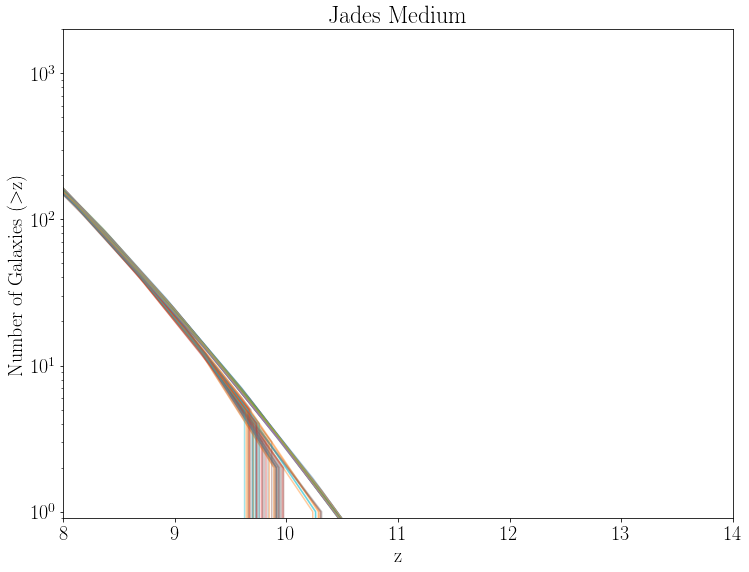

In [16]:
fig, ax = plt.subplots(figsize=(12,9))
summed=np.zeros(len(z_vals))
summean=np.zeros(len(z_vals))
for _ in tqdm(range(N)):   
    # Survey design matching the JADES Wide survey from Williams et al. 2018 (pg. 36)

    wide = survey(29.85, 190./3600, "cv_jades_wide.csv", nearest_wavelength(x,14873.4))
    mean_wide, med_wide, z_vals_wide = mean_median(wide)
    summed+=med_wide
    summean+=mean_wide

    ax.plot(z_vals_wide, mean_wide, alpha=0.4, label = "Mean")
    ax.plot(z_vals_wide, med_wide, alpha=0.4,label = "Median")

    ax.set(xlabel="z", ylabel="Number of Galaxies"r" ($>$z)", yscale="log", ylim=(0.9,2e3), xlim=(8,14), title='Jades Medium')
winsound.Beep(400,300)

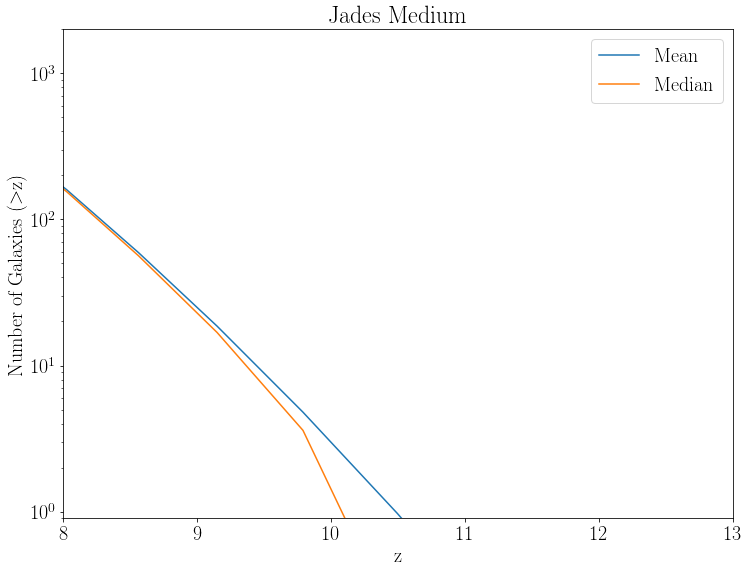

In [17]:
fig, ax =plt.subplots(figsize=(12,9))

ax.plot(z_vals, summean/N,label = "Mean")
ax.plot(z_vals, summed/N,label = "Median")
ax.legend()
ax.set(xlabel="z", ylabel="Number of Galaxies"r" ($>$z)", yscale="log", ylim=(0.9,2e3), xlim=(8,13), title='Jades Medium')
if save==1:
    plt.savefig("figs/"+file+"/jadesmedium.pdf")

In [18]:
fmed = interp1d(z_vals, summed/N, 'cubic')
fmean = interp1d(z_vals, summean/N, "cubic")
z_med, z_mean = find_min(fmed), find_min(fmean)
z_med, z_vals[73-max(np.argwhere(np.isnan(np.log(summed)+np.inf)).flatten())], z_mean

0.9997439337405627
0.9996945065644283


C:\Users\chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
C:\Users\chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in add
  after removing the cwd from sys.path.


(10.172999999998796, 10.4945, 10.482999999998624)

100%|███████████████████████████████████████████████████████████████████████████████| 50/50 [1:38:28<00:00, 118.17s/it]


0.9973504745895275
0.9993576401677885


C:\Users\chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in log
C:\Users\chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in add


(10.840999999998425, 10.4945, 11.081999999998292)

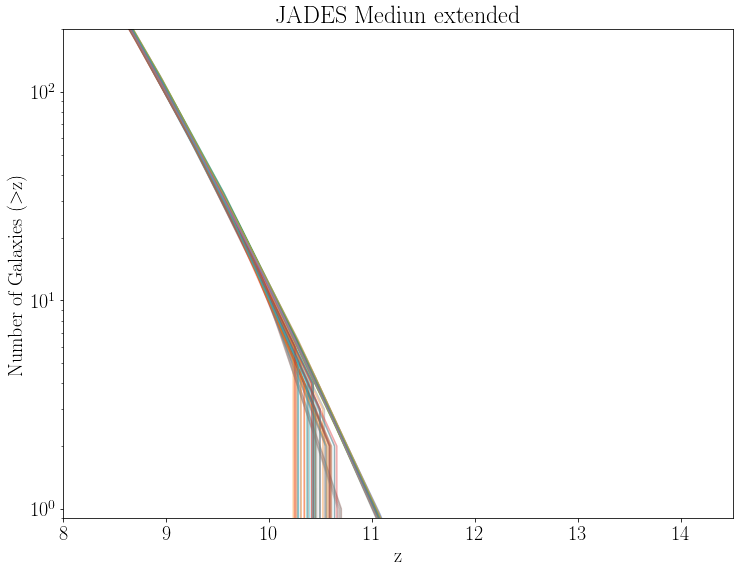

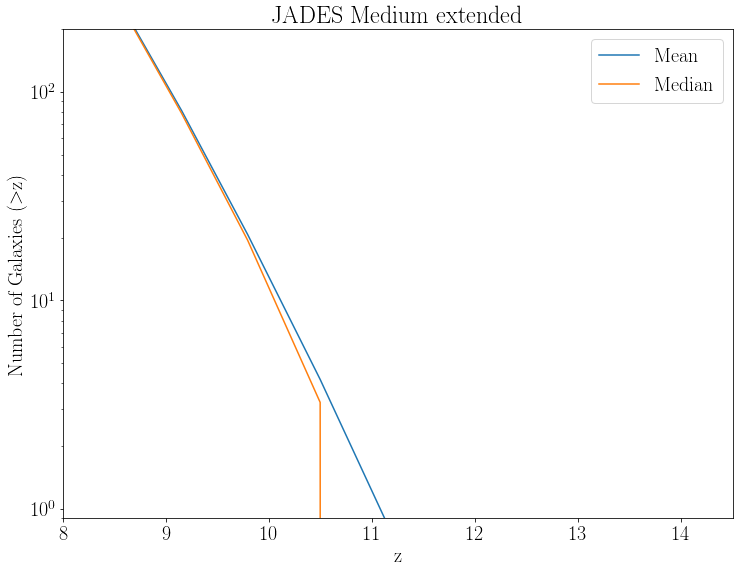

In [19]:
fig, ax = plt.subplots(figsize=(12,9))
meds, means = [],[]
summed=np.zeros(len(z_vals))
summean=np.zeros(len(z_vals))
for _ in tqdm(range(N)):   
    # Survey design matching the JADES Deep survey from Williams et al. 2018 (pg. 36)
    deep = survey(29.8, 5*190./3600, "cv_jades_medium_extend.csv", nearest_wavelength(x,14873.4))
    mean_deep, med_deep, z_vals_deep = mean_median(deep)
    summed+=med_deep
    summean+=mean_deep
    meds.append(med_deep)
    means.append(mean_deep)
    ax.plot(z_vals_deep, mean_deep, alpha=0.4, label = "Mean")
    ax.plot(z_vals_deep, med_deep, alpha=0.4,label = "Median")

    ax.set(xlabel="z", ylabel="Number of Galaxies"r" ($>$z)", yscale="log", ylim=(0.9,2e2), xlim=(8,14.5), title='JADES Mediun extended')
winsound.Beep(400,300)
fig, ax =plt.subplots(figsize=(12,9))

ax.plot(z_vals, summean/N,label = "Mean")
ax.plot(z_vals, summed/N,label = "Median")
ax.legend()
ax.set(xlabel="z", ylabel="Number of Galaxies"r" ($>$z)", yscale="log", ylim=(0.9,2e2), xlim=(8,14.5), title='JADES Medium extended')
if save==1:
    plt.savefig("figs/"+file+"/jadesmediumextend.pdf")
fmed = interp1d(z_vals, summed/N, 'cubic')
fmean = interp1d(z_vals, summean/N, "cubic")
z_med, z_mean = find_min(fmed), find_min(fmean)
z_med, z_vals[73-max(np.argwhere(np.isnan(np.log(summed)+np.inf)).flatten())], z_mean

100%|███████████████████████████████████████████████████████████████████████████████| 50/50 [1:40:10<00:00, 120.21s/it]


0.9981422738262368
0.9998233937803327


C:\Users\chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in log
C:\Users\chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in add


(12.503999999997504, 13.0755, 12.970999999997245)

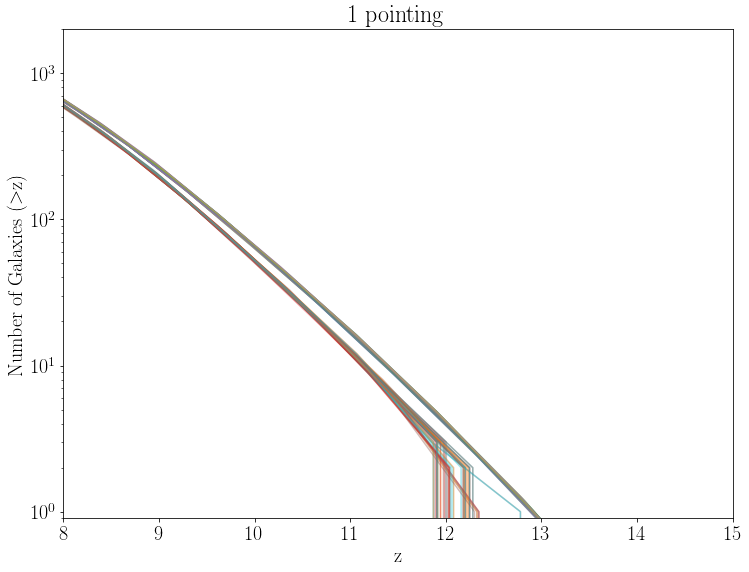

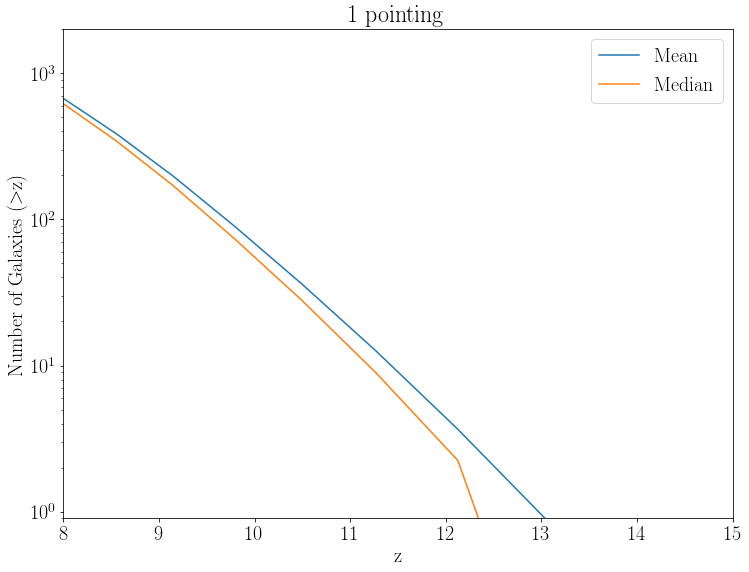

In [20]:
fig, ax = plt.subplots(figsize=(12,9))
summed=np.zeros(len(z_vals))
summean=np.zeros(len(z_vals))
for _ in tqdm(range(N)):   
    # Survey design assuming 35 parallel pointings of JWST
    # Uses limiting magnitude from JADES Deep, area of one JWST pointing

    parallel_35 = survey(32.2, 2*4.84/3600, "cv_one_pointing.csv", nearest_wavelength(x,14873.4), 1)
    mean_35, med_35, z_vals_35 = mean_median(parallel_35)
    summed+=med_35
    summean+=mean_35

    ax.plot(z_vals_35, mean_35, alpha=0.4, label = "Mean")
    ax.plot(z_vals_35, med_35, alpha=0.4,label = "Median")

    ax.set(xlabel="z", ylabel="Number of Galaxies"r" ($>$z)", yscale="log", ylim=(0.9,2e3), xlim=(8,15), title='1 pointing')
winsound.Beep(400,300)
fig, ax =plt.subplots(figsize=(12,9))

ax.plot(z_vals, summean/N,label = "Mean")
ax.plot(z_vals, summed/N,label = "Median")
ax.legend()
ax.set(xlabel="z", ylabel="Number of Galaxies"r" ($>$z)", yscale="log", ylim=(0.9,2e3), xlim=(8,15), title='1 pointing')
if save==1:
    plt.savefig("figs/"+file+"/1.pdf")
    
fmed = interp1d(z_vals, summed/N, 'cubic')
fmean = interp1d(z_vals, summean/N, "cubic")
z_med, z_mean = find_min(fmed), find_min(fmean)
z_med, z_vals[73-max(np.argwhere(np.isnan(np.log(summed)+np.inf)).flatten())], z_mean

100%|███████████████████████████████████████████████████████████████████████████████| 50/50 [2:08:57<00:00, 154.76s/it]


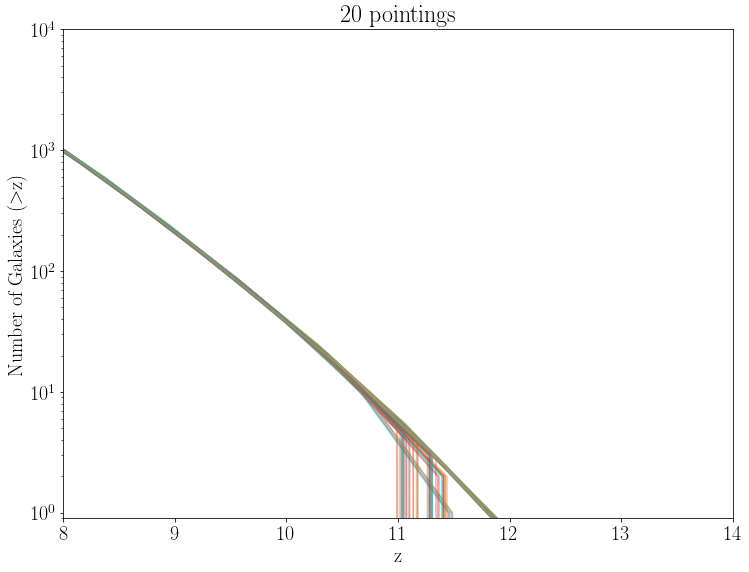

In [21]:
fig, ax = plt.subplots(figsize=(12,9))
summed=np.zeros(len(z_vals))
summean=np.zeros(len(z_vals))
for _ in tqdm(range(N)):   
    # Survey design assuming 35 parallel pointings of JWST
    # Uses limiting magnitude from JADES Deep, area of one JWST pointing

    parallel_35 = survey(30.7, 2*4.84/3600, "cv_one_pointing.csv", nearest_wavelength(x,14873.4), 20)
    mean_35, med_35, z_vals_35 = mean_median(parallel_35)
    summed+=med_35
    summean+=mean_35

    ax.plot(z_vals_35, mean_35, alpha=0.4, label = "Mean")
    ax.plot(z_vals_35, med_35, alpha=0.4,label = "Median")

    ax.set(xlabel="z", ylabel="Number of Galaxies"r" ($>$z)", yscale="log", ylim=(0.9,1e4), xlim=(8,14), title='20 pointings')
winsound.Beep(400,300)

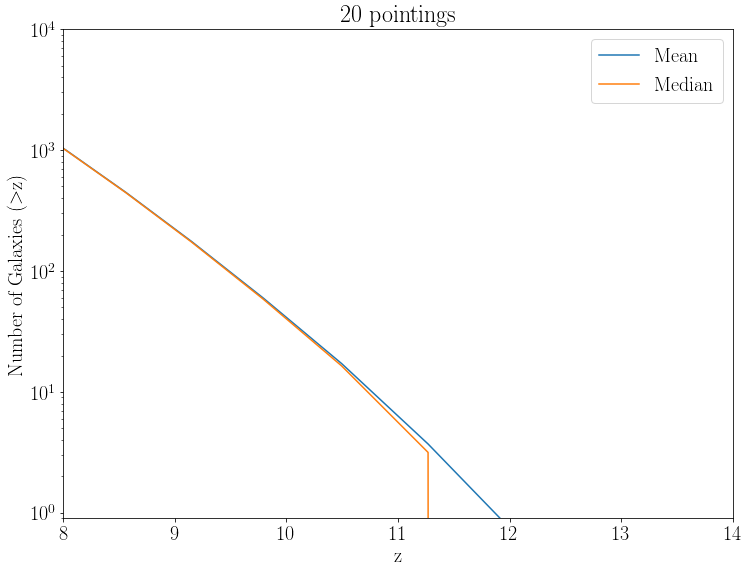

In [22]:
fig, ax =plt.subplots(figsize=(12,9))

ax.plot(z_vals, summean/N,label = "Mean")
ax.plot(z_vals, summed/N,label = "Median")
ax.legend()
ax.set(xlabel="z", ylabel="Number of Galaxies"r" ($>$z)", yscale="log", ylim=(0.9,1e4), xlim=(8,14), title='20 pointings')
if save==1:
    plt.savefig("figs/"+file+"/20.pdf")

In [23]:
fmed = interp1d(z_vals, summed/N, 'cubic')
fmean = interp1d(z_vals, summean/N, "cubic")
z_med, z_mean = find_min(fmed), find_min(fmean)
z_med, z_vals[73-max(np.argwhere(np.isnan(np.log(summed)+np.inf)).flatten())], z_mean

0.99920628269912
0.9989365302196295


C:\Users\chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
C:\Users\chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in add
  after removing the cwd from sys.path.


(11.651999999997976, 11.2695, 11.856999999997862)

100%|████████████████████████████████████████████████████████████████████████████████| 50/50 [1:05:23<00:00, 78.46s/it]


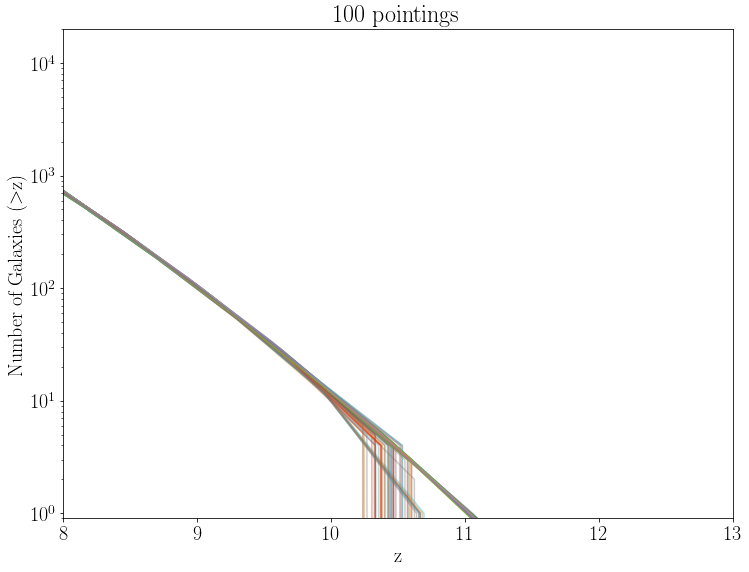

In [24]:
fig, ax = plt.subplots(figsize=(12,9))
summed=np.zeros(len(z_vals))
summean=np.zeros(len(z_vals))
for _ in tqdm(range(N)):   
    # Survey design assuming 100 parallel pointings of JWST

    parallel_200 = survey(29.8, 2*4.84/3600, "cv_one_pointing.csv", nearest_wavelength(x,14873.4), 100)
    mean_200, med_200, z_vals_200 = mean_median(parallel_200)
    summed+=med_200
    summean+=mean_200

    ax.plot(z_vals_200, mean_200, alpha=0.4, label = "Mean")
    ax.plot(z_vals_200, med_200, alpha=0.4,label = "Median")

    ax.set(xlabel="z", ylabel="Number of Galaxies"r" ($>$z)", yscale="log", ylim=(0.9,2e4), xlim=(8,13), title='100 pointings')
winsound.Beep(400,300)

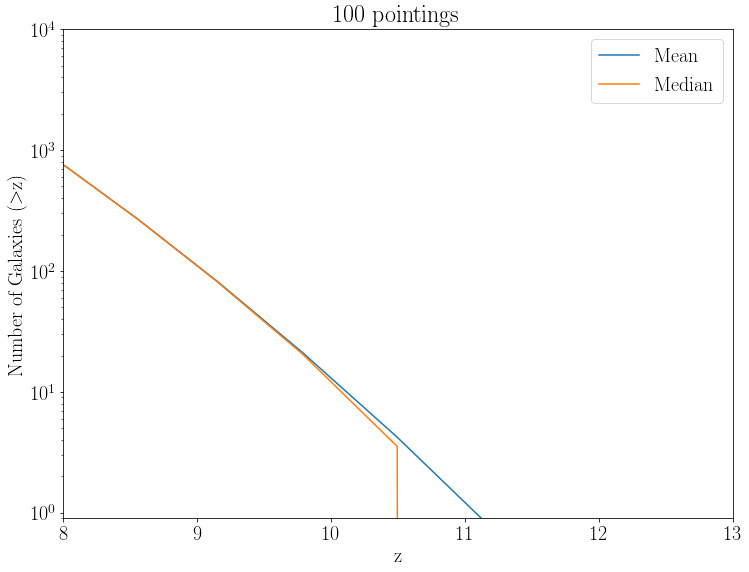

In [25]:
fig, ax =plt.subplots(figsize=(12,9))

ax.plot(z_vals, summean/N,label = "Mean")
ax.plot(z_vals, summed/N,label = "Median")
ax.legend()
ax.set(xlabel="z", ylabel="Number of Galaxies"r" ($>$z)", yscale="log", ylim=(0.9,1e4), xlim=(8,13), title='100 pointings')
if save==1:
    plt.savefig("figs/"+file+"/100.pdf")

In [26]:
fmed = interp1d(z_vals, summed/N, 'cubic')
fmean = interp1d(z_vals, summean/N, "cubic")
z_med, z_mean = find_min(fmed), find_min(fmean)
z_med, z_vals[73-max(np.argwhere(np.isnan(np.log(summed)+np.inf)).flatten())], z_mean

0.9991049626863311
0.9994006278970206


C:\Users\chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
C:\Users\chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in add
  after removing the cwd from sys.path.


(10.86799999999841, 10.4945, 11.081999999998292)

100%|████████████████████████████████████████████████████████████████████████████████| 50/50 [1:13:02<00:00, 87.64s/it]


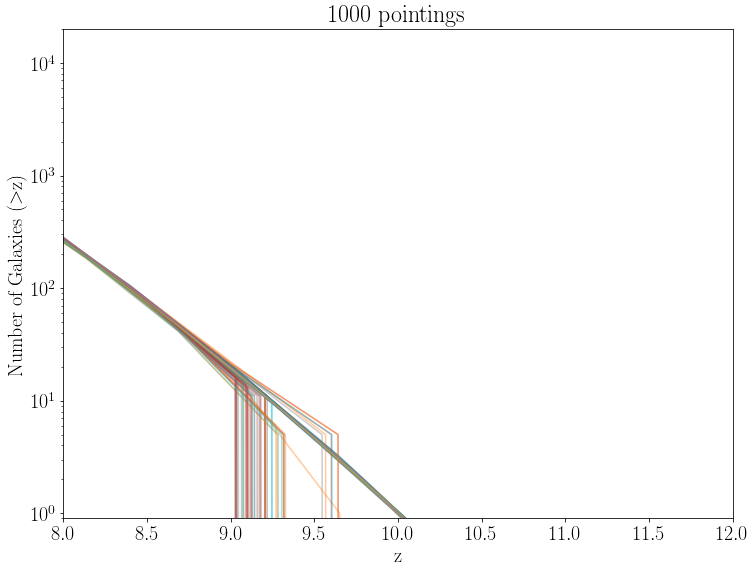

In [27]:
fig, ax = plt.subplots(figsize=(12,9))
summed=np.zeros(len(z_vals))
summean=np.zeros(len(z_vals))
for _ in tqdm(range(N)):   
    # Survey design assuming 200 parallel pointings of JWST

    parallel_2000 = survey(28.6, 2*4.84/3600, "cv_one_pointing.csv", nearest_wavelength(x,14873.4), 1000)
    mean_2000, med_2000, z_vals_2000 = mean_median(parallel_2000)
    summed+=med_2000
    summean+=mean_2000

    ax.plot(z_vals_2000, mean_2000, alpha=0.4, label = "Mean")
    ax.plot(z_vals_2000, med_2000, alpha=0.4,label = "Median")

    ax.set(xlabel="z", ylabel="Number of Galaxies"r" ($>$z)", yscale="log", ylim=(0.9,2e4), xlim=(8,12), title='1000 pointings')
winsound.Beep(400,300)

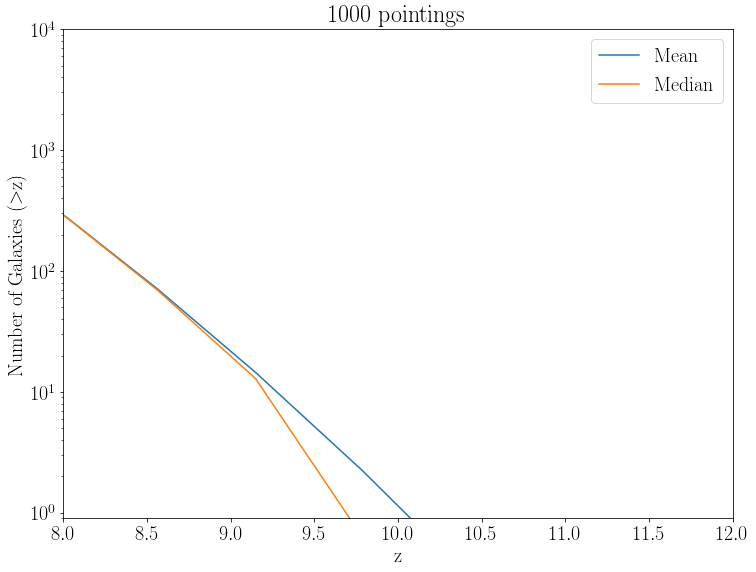

In [28]:
fig, ax =plt.subplots(figsize=(12,9))

ax.plot(z_vals, summean/N,label = "Mean")
ax.plot(z_vals, summed/N,label = "Median")
ax.legend()
ax.set(xlabel="z", ylabel="Number of Galaxies"r" ($>$z)", yscale="log", ylim=(0.9,1e4), xlim=(8,12), title='1000 pointings')
if save==1:
    plt.savefig("figs/"+file+"/1000.pdf")

In [29]:
fmed = interp1d(z_vals, summed/N, 'cubic')
fmean = interp1d(z_vals, summean/N, "cubic")
z_med, z_mean = find_min(fmed), find_min(fmean)
z_med, z_vals[73-max(np.argwhere(np.isnan(np.log(summed)+np.inf)).flatten())], z_mean

0.9940445215116492
0.9977893183198792


C:\Users\chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
C:\Users\chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in add
  after removing the cwd from sys.path.


(9.733999999999039, 9.7905, 10.025999999998877)

100%|████████████████████████████████████████████████████████████████████████████████| 50/50 [1:05:35<00:00, 78.71s/it]


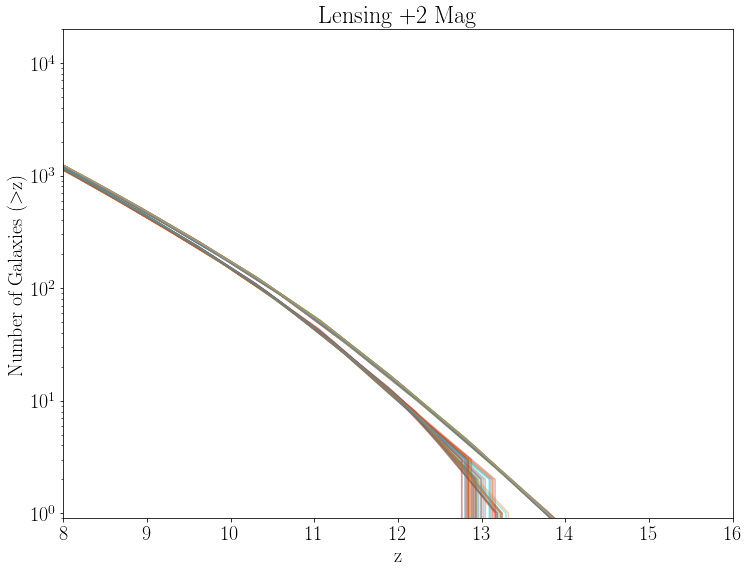

In [30]:
fig, ax = plt.subplots(figsize=(12,9))
summed=np.zeros(len(z_vals))
summean=np.zeros(len(z_vals))
for _ in tqdm(range(N)):   
# Survey design modeling the effect of lensing by increasing limiting magnitude of JADES Deep survey by 2
# Assumes this is over one JWST pointing

    lensing_2 = survey(30.7 + 2, 2*4.84/3600, "cv_jades_deep.csv", nearest_wavelength(x,14873.4), 1)
    mean_lens, med_lens, z_vals_lens = mean_median(lensing_2)
    summed+=med_lens
    summean+=mean_lens

    ax.plot(z_vals_lens, mean_lens, alpha=0.4, label = "Mean")
    ax.plot(z_vals_lens, med_lens, alpha=0.4,label = "Median")

    ax.set(xlabel="z", ylabel="Number of Galaxies"r" ($>$z)", yscale="log", ylim=(0.9,2e4), xlim=(8,16), title='Lensing +2 Mag')
winsound.Beep(400,300)

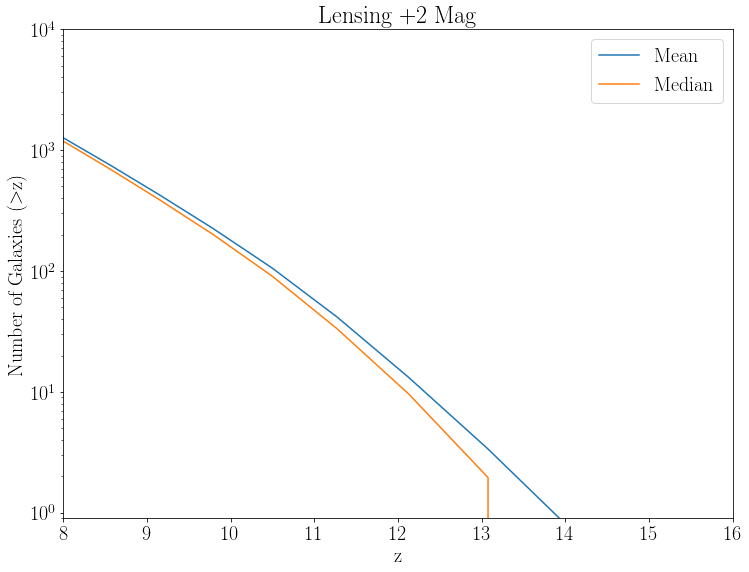

In [31]:
fig, ax =plt.subplots(figsize=(12,9))

ax.plot(z_vals, summean/N,label = "Mean")
ax.plot(z_vals, summed/N,label = "Median")
ax.legend()
ax.set(xlabel="z", ylabel="Number of Galaxies"r" ($>$z)", yscale="log", ylim=(0.9,1e4), xlim=(8,16), title='Lensing +2 Mag')
if save==1:
    plt.savefig("figs/"+file+"/lensfull+2.pdf")

In [32]:
fmed = interp1d(z_vals, summed/N, 'cubic')
fmean = interp1d(z_vals, summean/N, "cubic")
z_med, z_mean = find_min(fmed), find_min(fmean)
z_med, z_vals[73-max(np.argwhere(np.isnan(np.log(summed)+np.inf)).flatten())], z_mean

0.9999471596237334
0.9994831399640621


C:\Users\chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
C:\Users\chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in add
  after removing the cwd from sys.path.


(13.387999999997014, 13.0755, 13.86399999999675)

100%|███████████████████████████████████████████████████████████████████████████████| 50/50 [2:04:33<00:00, 149.47s/it]


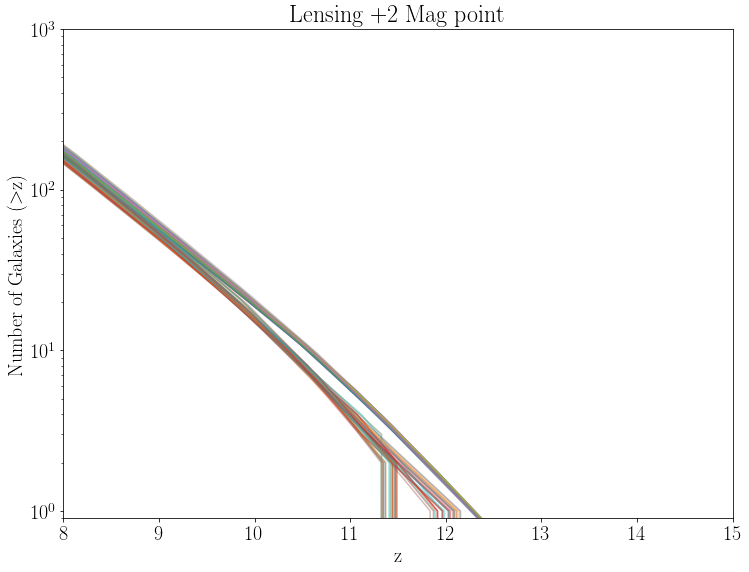

In [33]:
fig, ax = plt.subplots(figsize=(12,9))
summed=np.zeros(len(z_vals))
summean=np.zeros(len(z_vals))
for _ in tqdm(range(N)):   
    # Survey design modeling the effect of lensing by increasing limiting magnitude of JADES Deep survey by 2
    # Assumes this is over one square arcsecond
    lensing_2 = survey(30.7 + 2, 1/3600, "cv_jades_deep.csv", nearest_wavelength(x,14873.4), 1)
    mean_lens, med_lens, z_vals_lens = mean_median(lensing_2)
    lensing_rest = survey(30.7, 8.6/3600, "cv_jades_deep.csv", nearest_wavelength(x,14873.4), 1)
    mean_lens1, med_lens1, zvals1  = mean_median(lensing_rest)
    mean_lens+=mean_lens1
    med_lens+=med_lens1
    summed+=med_lens
    summean+=mean_lens

    ax.plot(z_vals_lens, mean_lens, alpha=0.4, label = "Mean")
    ax.plot(z_vals_lens, med_lens, alpha=0.4,label = "Median")

    ax.set(xlabel="z", ylabel="Number of Galaxies"r" ($>$z)", yscale="log", ylim=(0.9,1e3), xlim=(8,15), title='Lensing +2 Mag point')
winsound.Beep(400,300)

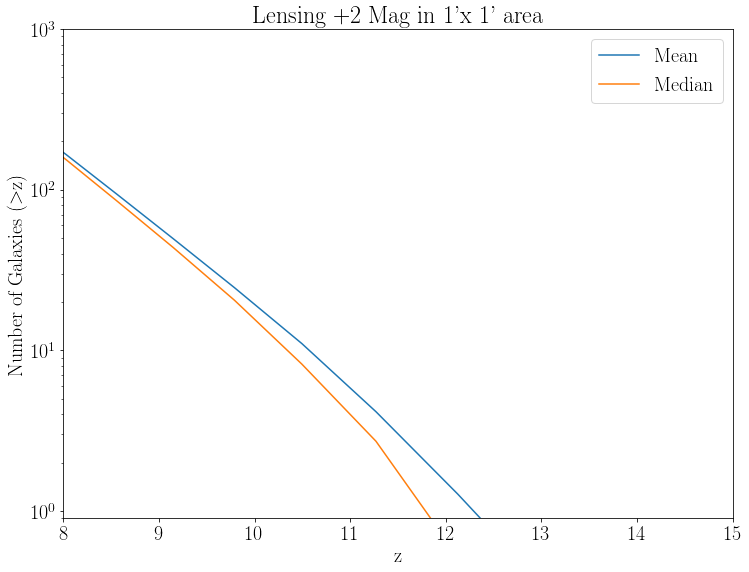

In [34]:
fig, ax =plt.subplots(figsize=(12,9))

ax.plot(z_vals, summean/N,label = "Mean")
ax.plot(z_vals, summed/N,label = "Median")
ax.legend()
ax.set(xlabel="z", ylabel="Number of Galaxies"r" ($>$z)", yscale="log", ylim=(0.9,1e3), xlim=(8,15), title="Lensing +2 Mag in 1'x 1' area")
if save==1:
    plt.savefig("figs/"+file+"/lenspoint+2.pdf")

In [35]:
fmed = interp1d(z_vals, summed/N, 'cubic')
fmean = interp1d(z_vals, summean/N, "cubic")
z_med, z_mean = find_min(fmed), find_min(fmean)
z_med, z_vals[73-max(np.argwhere(np.isnan(np.log(summed)+np.inf)).flatten())], z_mean

0.9995727826287056
0.998694103516945


C:\Users\chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
C:\Users\chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in add
  after removing the cwd from sys.path.


(11.835999999997874, 12.126, 12.29499999999762)